In [ ]:
import urllib.request
import pandas as pd
from osgeo import gdal, osr


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile


from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
import geopandas as gpd
import pysal as ps


from PIL import Image, ImageFilter
import cv2
import datetime
from datetime import timedelta



In [1]:
#RAIOS
from pykml import parser
import numpy as np

with open('radar_img/linet_0-15.kml') as f:
    folder = parser.parse(f).getroot().Document
coordList=[]
for pm in folder.Placemark:
    rawCoord = pm.Point.coordinates    
    coord = str(rawCoord).split(",")
    coordList.append(coord)
    
coordArray = np.array(coordList, dtype=float)
#Fazer Array de Lat e Lon, separado porimport os



Avaí
Barra do Turvo
Cajati
Campinas
Cananéia
Eldorado
Espírito Santo do Turvo
Glicério
Guaimbê
Guaratinguetá
Iporanga
Itupeva
Jacareí
Oriente
Quatá
Queiroz
Ribeirão do Sul
Santo Anastácio
Sud Mennucci
Valinhos
Vera Cruz
14.548688411712646
Estimated number of clusters: 12
Estimated number of noise points: 138


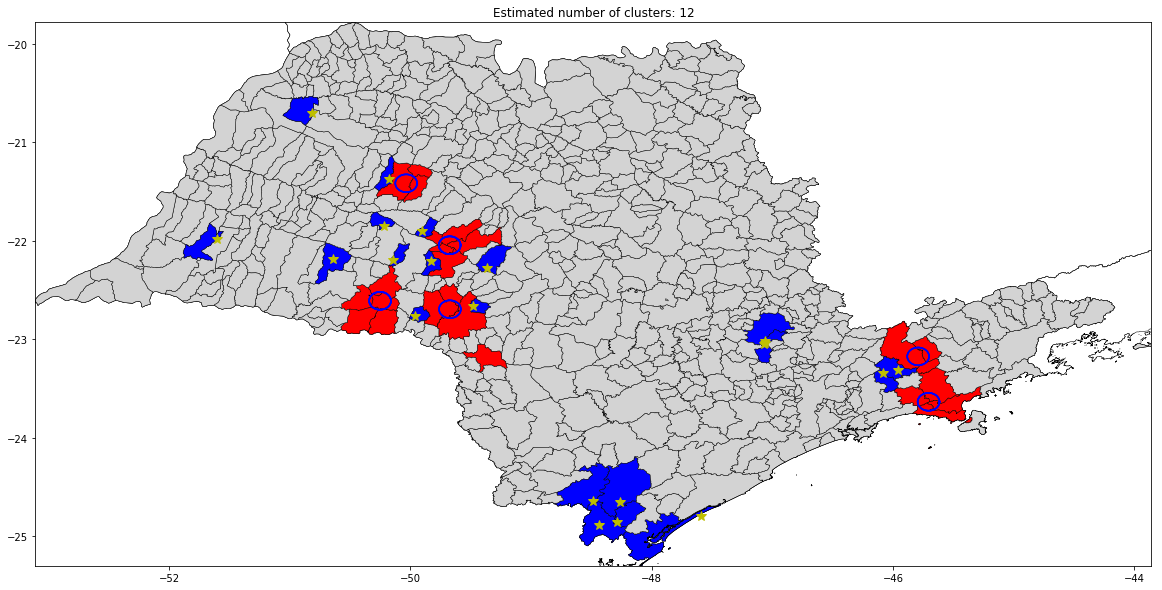

In [3]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import time
import shapefile
from matplotlib.patches import Polygon as poli
from shapely.geometry import Polygon
from shapely.geometry import Point

def shapePatch(shape, color):
    npoints=len(shape.points) # total points
    nparts = len(shape.parts) # total parts
    if nparts == 1:
        shp = shape.points
        poligon = poli(shp, facecolor=color, edgecolor='black', linewidth=0.5)
        ax.add_patch(poligon)
    else:
        for ip in range(nparts):
            i0 = shape.parts[ip]
            if ip < nparts-1:
                i1 = shape.parts[ip+1]-1
            else:
                i1 = npoints    
            seg=shape.points[i0:i1+1]
            poligon = poli(seg, facecolor=color, edgecolor='black', linewidth=0.5)
            ax.add_patch(poligon)


start = time.time()
raio = 10000
r_d = raio/110744
buffer_ratio = (r_d)*(1-0.99919687401213+1) #Variavel que converte buffer em metros

#Abre os arquivos shapefile do BR
fname2 = 'gadm/gadm36_BRA_2.shp'
fname1 = 'gadm/gadm36_BRA_1.shp'

sf = shapefile.Reader(fname2)
sfBr = shapefile.Reader(fname1)
shapes = sf.shapes()

#Cluester em DBSCAN dos pontos. de 1400 foi pra 160
db = DBSCAN(eps=0.09, min_samples=10).fit(coordArray)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
unique_labels = set(labels)

fig, ax = plt.subplots(figsize=(20,10))
#Projecao do mapa
states = sfBr.shapes()
a,b,c,d = states[24].bbox
plt.xlim(a,c)
plt.ylim(b,d)
for state in states:
    shapePatch(state, 'none') 
#Loop para todas as cidades do estado de sao paulo e passa cada ponto de dado

for city, shape in zip(sf.iterRecords(), sf.iterShapes()):
    if city[3] == 'São Paulo':
        cor = 'lightgray'        
        
        shape_ex = shape.points
        polygon = Polygon(shape_ex)
        
        for k in unique_labels:
            class_member_mask = (labels == k)
            if k != -1:
#----Aki sao os clusters. Usa um centroid como base e faz o buffer que cobre uma area
                xy = coordArray[class_member_mask & core_samples_mask]
                X = np.mean(xy[:,0])
                Y = np.mean(xy[:,1])
                TS = Point(X,Y).buffer(buffer_ratio)
                if polygon.intersects(TS):
                    X, Y = TS.exterior.coords.xy
                    plt.plot(X, Y,'b')
                    #print(city[6])
                    cor = 'r'
                    break
            else:
#----Aki sao os pontos isolados. E ha um array de pontos aki. Por isso o do loop interno.
                xy = coordArray[class_member_mask & ~core_samples_mask]
                for X, Y in xy:
                    point = Point(X,Y)
                    if polygon.contains(point):
                        plt.plot(X, Y, 'y*', markersize=10)
                        print(city[6])
                        cor = 'b'
                        break
#---Plot das cidades.  
        shapePatch(shape, cor) 
            


end = time.time()
print (end - start)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

plt.title('Estimated number of clusters: %d' % n_clusters_) 
ax.autoscale_view()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile
from matplotlib.patches import Polygon
import time



fname1 = 'gadm/gadm36_BRA_1.shp'
fname2 = 'gadm/gadm36_BRA_2.shp'

sf = shapefile.Reader(fname2)
sfBr = shapefile.Reader(fname1)
shapes = sf.shapes()

sfMap = Reader(fname2)

start = time.time()

ax = plt.axes(projection=ccrs.Robinson())

ax.set_extent([-80, -25, -35, 5])

ax.add_geometries(Reader(fname1).geometries(), ccrs.PlateCarree()
                  ,facecolor='lightgray', edgecolor='black', linewidth=1)
'''
# construction of a dctionary field_name:value  
for record, geometry in zip(sfMap.records(), sfMap.geometries()):
    if record.attributes['NAME_1'] == 'São Paulo':
        cor = 'b'
        ax.add_geometries([geometry], ccrs.PlateCarree(),
                          facecolor=cor, edgecolor='black', linewidth=0.5)
'''
plt.show()
end = time.time()
print (end - start)


GID_0: BRA
NAME_0:Country name eg: Brazil
GID_1: BRA.1_1
NAME_1: Estate name (eg: São Paulo)
VARNAME_1: ''
NL_NAME_1: ''
NAME_2: Campinas
VARNAME_2: ''
NL_NAME_2: ''
TYPE_1: Estado
ENGTYPE_1: State
CC_1: ''
HASC_1: BR.AC

dataSource = ogr.Open(daShapefile)
daLayer = dataSource.GetLayer(0)
layerDefinition = daLayer.GetLayerDefn()
feature = daLayer.GetNextFeature()
while feature:
    print(feature)
    # do something here
    feature = daLayer.GetNextFeature()
daLayer.ResetReading()


for i in range(layerDefinition.GetFieldCount()):
    fieldName =  layerDefinition.GetFieldDefn(i).GetName()
    fieldTypeCode = layerDefinition.GetFieldDefn(i).GetType()
    fieldType = layeimport matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile
import time

start = time.time()
fname = 'gadm/gadm36_BRA_2.shp'
fname2 = 'gadm/gadm36_BRA_1.shp'

ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-54, -44, -25.5, -19.5])

sf = Reader(fname)

print (sf.records())rDefinition.GetFieldDefn(i).GetFieldTypeName(fieldTypeCode)
    fieldWidth = layerDefinition.GetFieldDefn(i).GetWidth()
    GetPrecision = layerDefinition.GetFieldDefn(i).GetPrecision()

    print (fieldName + " - " + fieldType+ " " + str(fieldWidth) + " " + str(GetPrecision))

PLOT DO MAPA DE SAO PAULO COM SHAPEFILE DOS MUNICIPIOS

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile
import time

start = time.time()
fname = 'gadm/gadm36_BRA_2.shp'
fname2 = 'gadm/gadm36_BRA_1.shp'

ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-54, -44, -25.5, -19.5])

sf = Reader(fname)

print (sf.records())

DOWNLOAD DE IMAGEM DE RADAR DO IPMET

In [ ]:
minuto = ['00', '15', '30', '45']
segundo = '00'
now = datetime.datetime.utcnow() - timedelta(hours=3)

#IPMET
url_ipmet = "https://www.ipmet.unesp.br/restrito/imagens_radar/ppi_int/"
for m in minuto[::-1]:
    try:
        last_ipmet = now.strftime("%y%m%d%H."+str(m+"A"))
        urllib.request.urlretrieve(url_ipmet+last_ipmet, "radar_img/last_ipmet.gif")
        urllib.request.urlretrieve(url_ipmet+last_ipmet, now_utc.strftime('radar_img/%H%M.gif'))
        print (url_ipmet+last_ipmet)
        break
    except:
        pass

CONVERÇAO DE IMAGEM PRA POSICAO

In [ ]:
img = Image.open('radar_img/last_ipmet.gif',)
img.save("radar_img/last_ipmet.tiff",'tiff', optimize=True, quality=100)

src_filename ='radar_img/last_ipmet.tiff' 
dst_filename = 'radar_img/dest.tiff'

img4=np.array(img.convert('RGB'))
print(img4.shape)
img2 = cv2.imread(src_filename)
print (img2.shape)
img5=img2-img4

img3 = cv2.imread('radar_img/last_ipmet.gif')
color=('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img5],[i],None,[256],[110,256])
    plt.plot(hist,color=col)
    plt.xlim([0,256])
plt.show()

# Opens source dataset
src_ds = gdal.Open(src_filename)
print(src_ds.GetProjection())
format = "GTiff"
driver = gdal.GetDriverByName(format)

# Open destination dataset
dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# Specify raster location through geotransform array
# (uperleftx, scalex, skewx, uperlefty, skewy, scaley)
# Scale = size of one pixel in units of raster projection
# this example below assumes 100x100
gt = [-7916400, 100, 0, 5210940, 0, -100]

# Set location
dst_ds.SetGeoTransform(gt)

# Get raster projection
epsg = 3857
srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg)
dest_wkt = srs.ExportToWkt()

# Set projection
dst_ds.SetProjection(dest_wkt)

# Close files
dst_ds = None
src_ds = None
#image1 = cv2.imread("local.gif")
#cv2.imshow('image',image1)
#Redemet
#tamanho da imagem. px
#Tamanho da imagem. km
#Posiçao do Centro. lat/lon
# 1km = 0.008 lat
# (n km/40000) * 360
#Criar quadrado com 500km de largura = PosX e Y da imagem




#image3 = image1 - image2j

#NAME_1 = Estado
#NAME_2 = Cidade

DOWNLOAD DE IMAGEM DE RADAR DO REDEMET

In [ ]:

now_utc = datetime.datetime.utcnow()
utc_ano = now_utc.strftime("%Y")
utc_mes = now_utc.strftime("%m")
utc_dia = now_utc.strftime("%d")
url_redemet = "https://www.redemet.aer.mil.br/radar/"+utc_ano+"/"+utc_mes+"/"+utc_dia+"/sr/maxcappi/maps/"
print (now_utc)
print (url_redemet)
flag = 0
for h in range(now_utc.hour, now_utc.hour-2, -1):
    for m in range(56, 6 , -10):
        for s in range (15,10,-1):
            if (flag == 0):
                try:
                    last_redemet = now_utc.strftime("%Y-%m-%d--")+str(h).zfill(2)+":"+str(m).zfill(2)+":"+str(s).zfill(2)+".png"
                    urllib.request.urlretrieve(url_redemet+last_redemet, 'radar_img/last_redemet.png')
                    urllib.request.urlretrieve(url_redemet+last_redemet, now_utc.strftime('radar_img/'+str(h).zfill(2)+str(m).zfill(2)+'.png'))
                    flag = 1
                    print (last_redemet)
                    break
                except:
                    pass

colourImg = Image.open("radar_img/last_redemet.png")
